# Sample X-ray Images: CheXpert vs NIH

Visualise representative X-ray images for each of the 7 common pathologies and for the *no-pathology* case.

| Column | Description |
|--------|-------------|
| **CheXpert (raw)** | Original image after XRV intensity normalisation, no spatial transform — variable size |
| **CheXpert (transformed)** | Same image after `XRayCenterCrop` + `XRayResizer(224)` — always 224×224 |
| **NIH** | Already stored at 224×224 in `images-224/`; no spatial transform applied |

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path

import torchxrayvision as xrv

from wcp_l2d.data import load_and_align_dataset, apply_xrv_transforms
from wcp_l2d.pathologies import COMMON_PATHOLOGIES

# ---- paths ---------------------------------------------------------------
DATA_DIR        = Path('../data')
CHEXPERT_PATH   = str(DATA_DIR / 'chexpert')
NIH_PATH        = str(DATA_DIR / 'NIH' / 'images-224' / 'images-224')

plt.rcParams.update({
    'figure.dpi': 100,
    'figure.facecolor': 'white',
})
print('Paths OK')
print(f'  CheXpert: {CHEXPERT_PATH}')
print(f'  NIH:      {NIH_PATH}')

Paths OK
  CheXpert: ../data/chexpert
  NIH:      ../data/NIH/images-224/images-224


In [2]:
# CheXpert — raw (no spatial transform, variable size)
print('Loading CheXpert (raw) ...')
chex_raw = load_and_align_dataset('chexpert', CHEXPERT_PATH)

# CheXpert — with XRayCenterCrop + XRayResizer(224)
print('Loading CheXpert (transformed) ...')
chex_tx = load_and_align_dataset('chexpert', CHEXPERT_PATH)
apply_xrv_transforms(chex_tx, size=224)

# NIH — already 224x224, no transform needed
print('Loading NIH ...')
nih = load_and_align_dataset('nih', NIH_PATH)

print(f'\nCheXpert samples : {len(chex_raw)}')
print(f'NIH samples      : {len(nih)}')
print(f'Pathologies      : {COMMON_PATHOLOGIES}')

Loading CheXpert (raw) ...


{np.str_('Enlarged Cardiomediastinum'), np.str_('Fracture'), np.str_('Support Devices'), np.str_('Lung Lesion'), np.str_('Lung Opacity'), np.str_('Pleural Other')} will be dropped
Loading CheXpert (transformed) ...


{np.str_('Enlarged Cardiomediastinum'), np.str_('Fracture'), np.str_('Support Devices'), np.str_('Lung Lesion'), np.str_('Lung Opacity'), np.str_('Pleural Other')} will be dropped
Loading NIH ...
{'Emphysema', 'Fibrosis', 'Mass', 'Hernia', 'Infiltration', 'Nodule', 'Pleural_Thickening'} will be dropped

CheXpert samples : 64534
NIH samples      : 30805
Pathologies      : ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Pneumonia', 'Pneumothorax']


In [3]:
def find_sample_indices(dataset, pathology_idx=None, no_pathology=False,
                        n=1, seed=0):
    """
    Return `n` dataset indices for a given pathology or for the no-pathology case.

    For `no_pathology=True`: samples where nanmax across all 7 labels == 0
    (i.e. no common pathology is labelled positive).
    For a specific pathology: samples where that label is exactly 1.
    """
    labels = dataset.labels  # shape [N, 7]
    rng = np.random.RandomState(seed)

    if no_pathology:
        # nanmax==0: all non-NaN labels are 0
        with np.errstate(all='ignore'):
            row_max = np.nanmax(labels, axis=1)
        mask = row_max == 0
    else:
        mask = labels[:, pathology_idx] == 1

    candidates = np.where(mask)[0]
    if len(candidates) == 0:
        return []
    chosen = rng.choice(candidates, size=min(n, len(candidates)), replace=False)
    return chosen.tolist()


def img_for_display(img_array):
    """
    Convert an xrv image array (shape [1,H,W] or [H,W]) to a float32 array
    in [0,1] suitable for plt.imshow(..., cmap='gray').
    """
    arr = np.asarray(img_array, dtype=np.float32)
    if arr.ndim == 3:
        arr = arr[0]          # drop channel dim
    lo, hi = arr.min(), arr.max()
    if hi > lo:
        arr = (arr - lo) / (hi - lo)
    else:
        arr = np.zeros_like(arr)
    return arr


print('Helper functions defined.')

Helper functions defined.


## Quick sanity-check — count positive labels per pathology

In [4]:
import pandas as pd

rows = []
for i, p in enumerate(COMMON_PATHOLOGIES):
    chex_pos = (chex_raw.labels[:, i] == 1).sum()
    nih_pos  = (nih.labels[:, i] == 1).sum()
    rows.append({'Pathology': p,
                 'CheXpert positives': chex_pos,
                 'NIH positives': nih_pos})

# No-pathology counts
with np.errstate(all='ignore'):
    chex_no = (np.nanmax(chex_raw.labels, axis=1) == 0).sum()
    nih_no  = (np.nanmax(nih.labels,      axis=1) == 0).sum()
rows.insert(0, {'Pathology': 'No Pathology',
                'CheXpert positives': chex_no,
                'NIH positives': nih_no})

df = pd.DataFrame(rows)
print(df.to_string(index=False))

    Pathology  CheXpert positives  NIH positives
 No Pathology               23949          26979
  Atelectasis               12691           1665
 Cardiomegaly                9099            777
Consolidation                5390            436
        Edema               14929             78
     Effusion               20640           1240
    Pneumonia                2822            174
 Pneumothorax                4311            252


## Main Visualisation

One representative image per row (8 rows = No Pathology + 7 pathologies),  
three columns: **CheXpert raw** | **CheXpert transformed** | **NIH**.

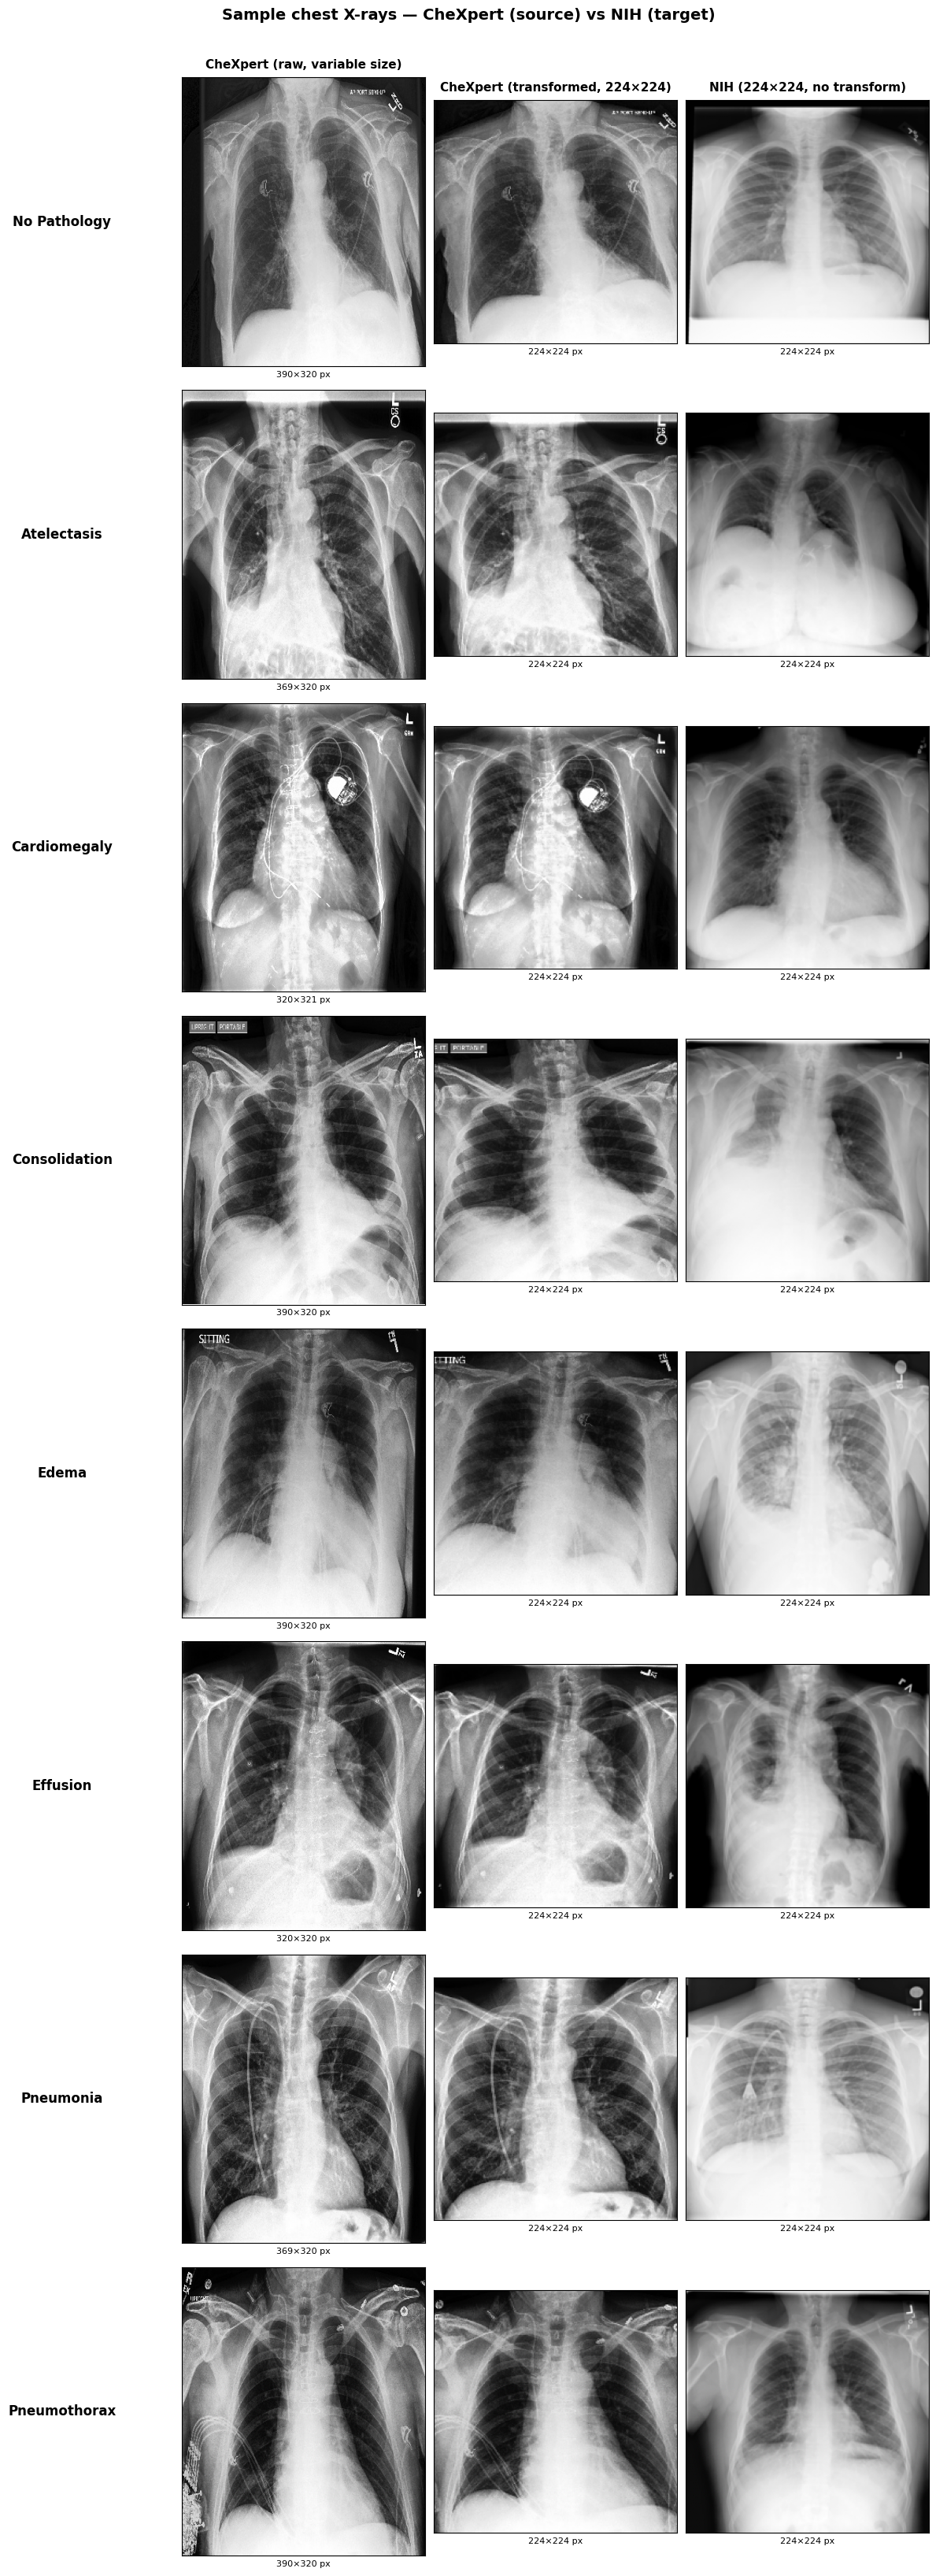

In [5]:
CATEGORIES = ['No Pathology'] + COMMON_PATHOLOGIES  # 8 rows
COL_TITLES = [
    'CheXpert (raw, variable size)',
    'CheXpert (transformed, 224×224)',
    'NIH (224×224, no transform)',
]
N_ROWS = len(CATEGORIES)
N_COLS = len(COL_TITLES)

fig, axes = plt.subplots(N_ROWS, N_COLS,
                         figsize=(N_COLS * 4, N_ROWS * 4 + 0.5))

# column headers (top row annotation)
for col, title in enumerate(COL_TITLES):
    axes[0, col].set_title(title, fontsize=11, fontweight='bold', pad=8)

for row_i, category in enumerate(CATEGORIES):
    no_path = (category == 'No Pathology')
    path_idx = None if no_path else COMMON_PATHOLOGIES.index(category)

    # find one sample per dataset
    chex_idxs = find_sample_indices(chex_raw, path_idx, no_path, n=1, seed=row_i * 7)
    nih_idxs  = find_sample_indices(nih,       path_idx, no_path, n=1, seed=row_i * 7 + 3)

    # ---- column 0 : CheXpert raw ----------------------------------------
    ax = axes[row_i, 0]
    if chex_idxs:
        idx = chex_idxs[0]
        sample = chex_raw[idx]
        arr = img_for_display(sample['img'])
        ax.imshow(arr, cmap='gray', aspect='auto')
        h, w = arr.shape
        ax.set_xlabel(f'{w}×{h} px', fontsize=8)
    else:
        ax.text(0.5, 0.5, 'no sample', ha='center', va='center',
                transform=ax.transAxes, fontsize=10, color='gray')
    ax.set_xticks([]); ax.set_yticks([])

    # ---- column 1 : CheXpert transformed ------------------------------------
    ax = axes[row_i, 1]
    if chex_idxs:
        idx = chex_idxs[0]
        sample = chex_tx[idx]   # same index, transforms applied
        arr = img_for_display(sample['img'])
        ax.imshow(arr, cmap='gray')
        h, w = arr.shape
        ax.set_xlabel(f'{w}×{h} px', fontsize=8)
    else:
        ax.text(0.5, 0.5, 'no sample', ha='center', va='center',
                transform=ax.transAxes, fontsize=10, color='gray')
    ax.set_xticks([]); ax.set_yticks([])

    # ---- column 2 : NIH ------------------------------------------------------
    ax = axes[row_i, 2]
    if nih_idxs:
        idx = nih_idxs[0]
        sample = nih[idx]
        arr = img_for_display(sample['img'])
        ax.imshow(arr, cmap='gray')
        h, w = arr.shape
        ax.set_xlabel(f'{w}×{h} px', fontsize=8)
    else:
        ax.text(0.5, 0.5, 'no sample', ha='center', va='center',
                transform=ax.transAxes, fontsize=10, color='gray')
    ax.set_xticks([]); ax.set_yticks([])

    # row label on the left
    axes[row_i, 0].set_ylabel(
        category, fontsize=12, fontweight='bold',
        rotation=0, labelpad=110, va='center'
    )

plt.suptitle(
    'Sample chest X-rays — CheXpert (source) vs NIH (target)',
    fontsize=14, fontweight='bold', y=1.005
)
plt.tight_layout()
plt.show()

## Multiple Examples Per Pathology

Show 3 examples side-by-side for each dataset × pathology combination  
(after transform only, for compactness).

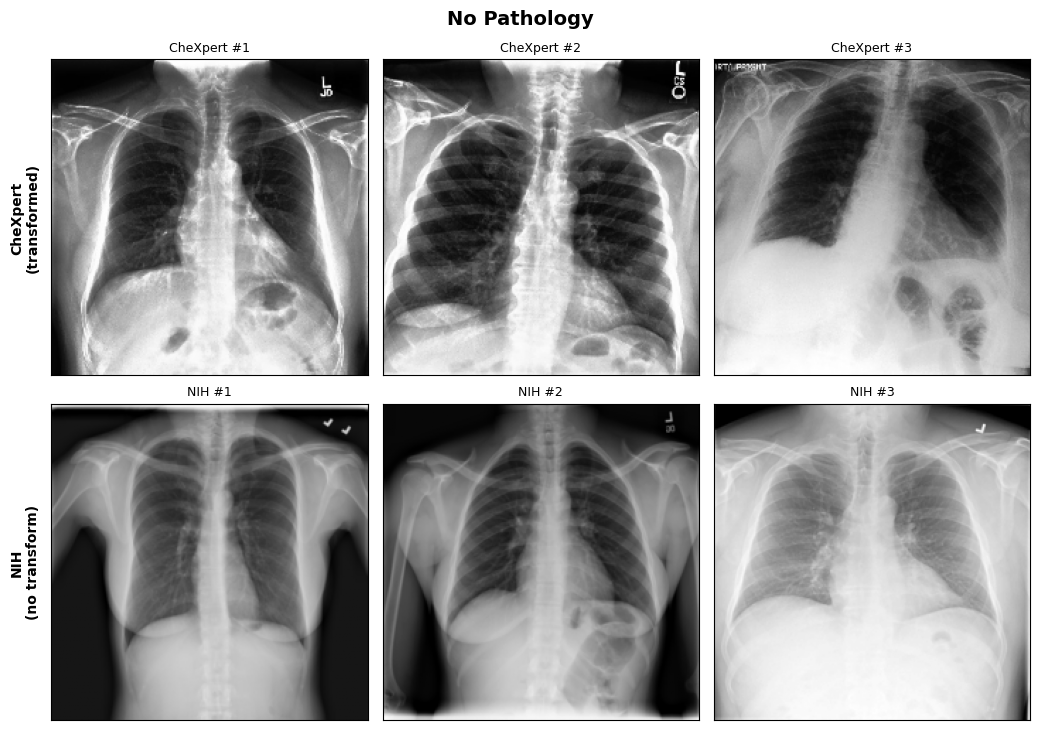

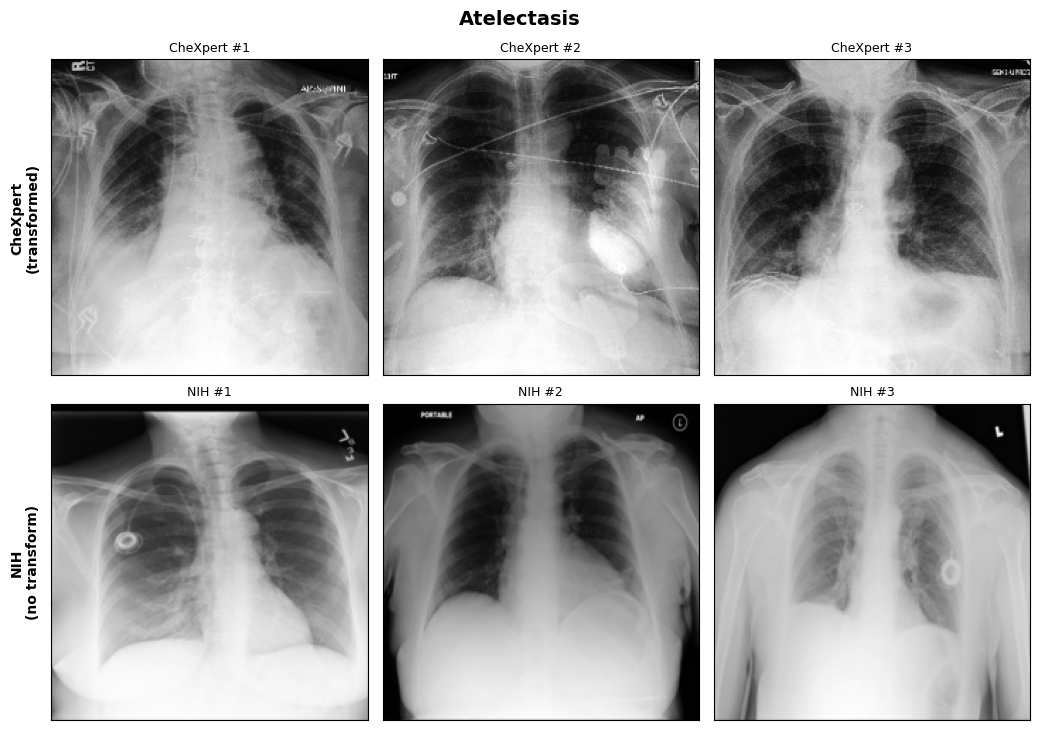

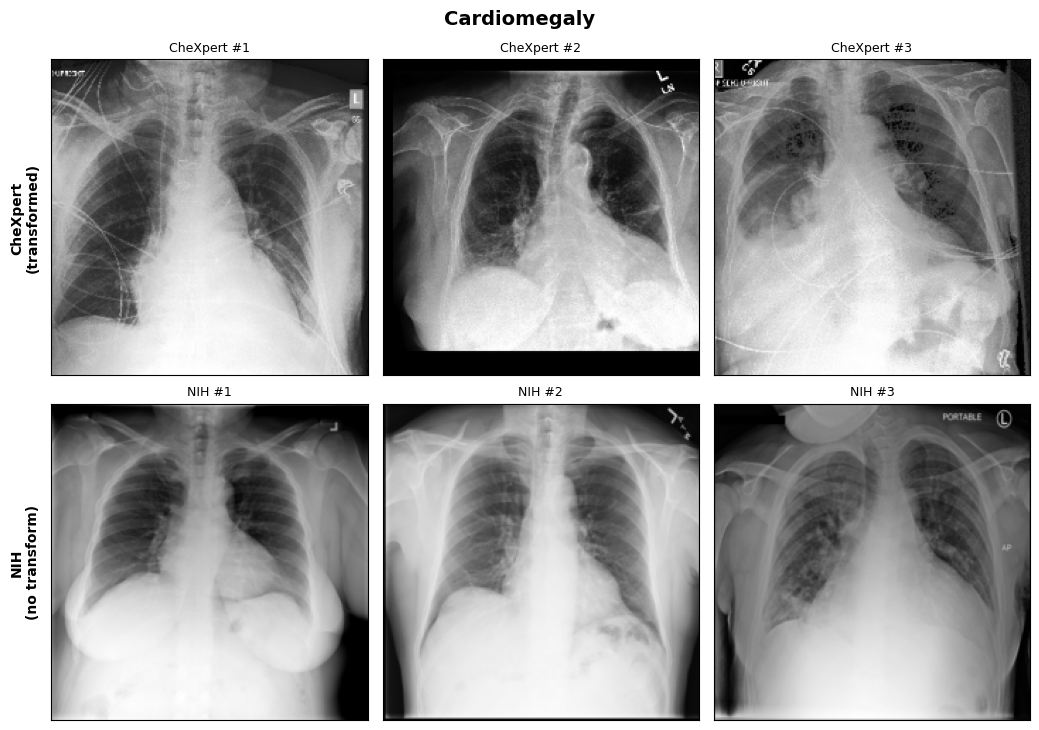

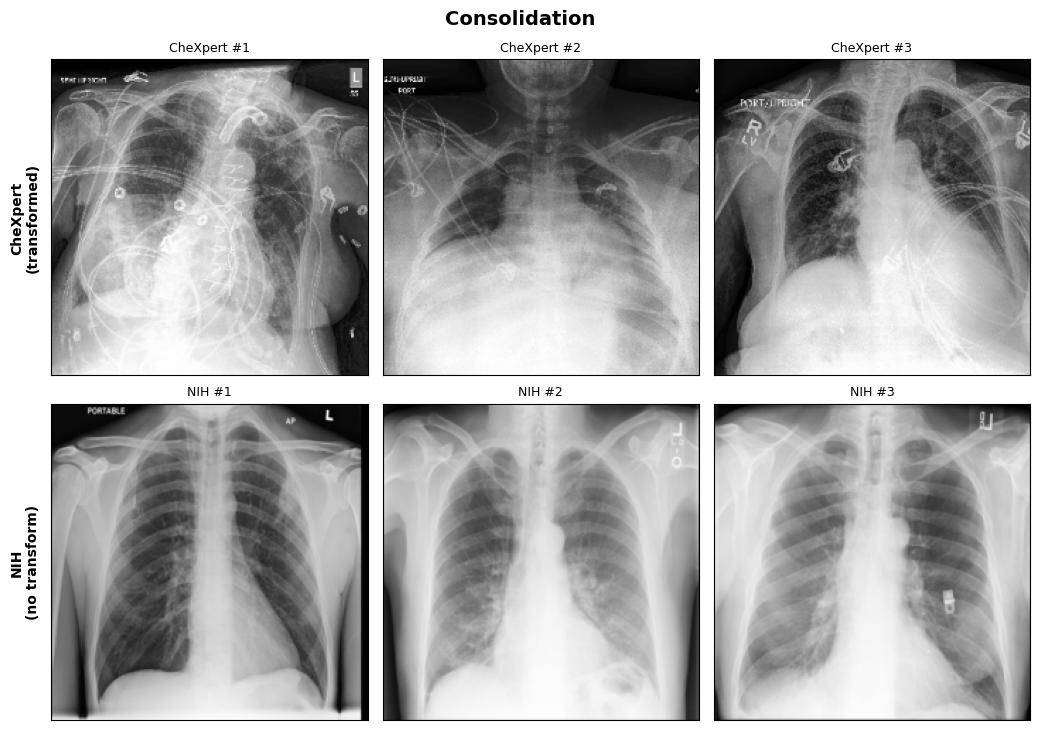

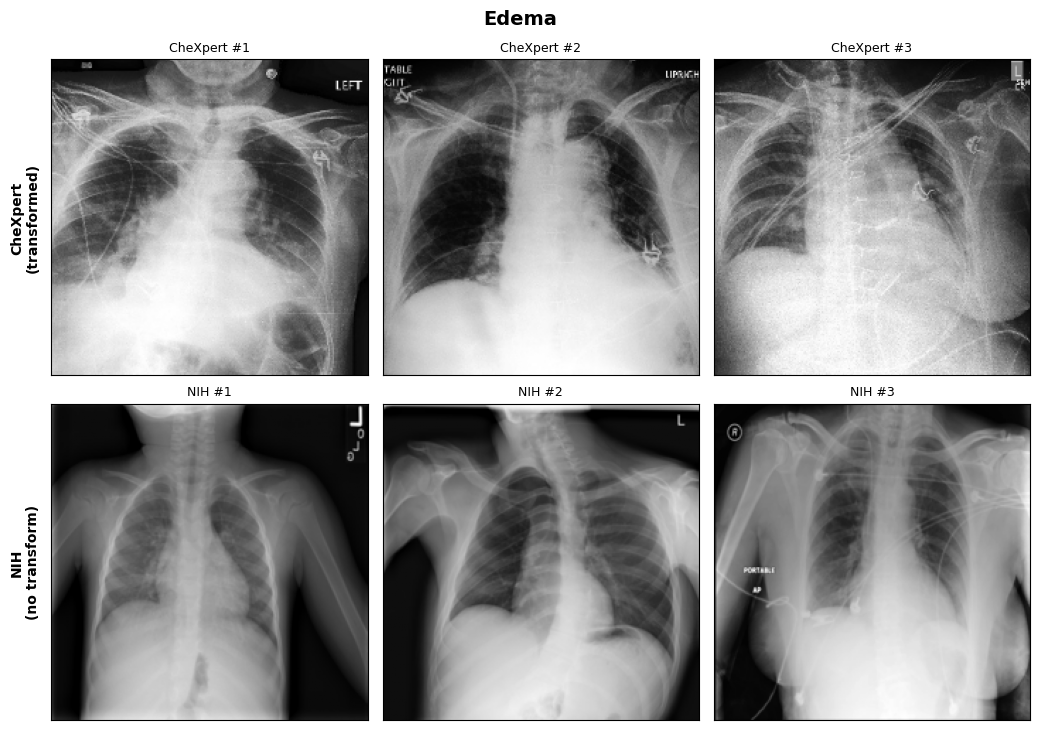

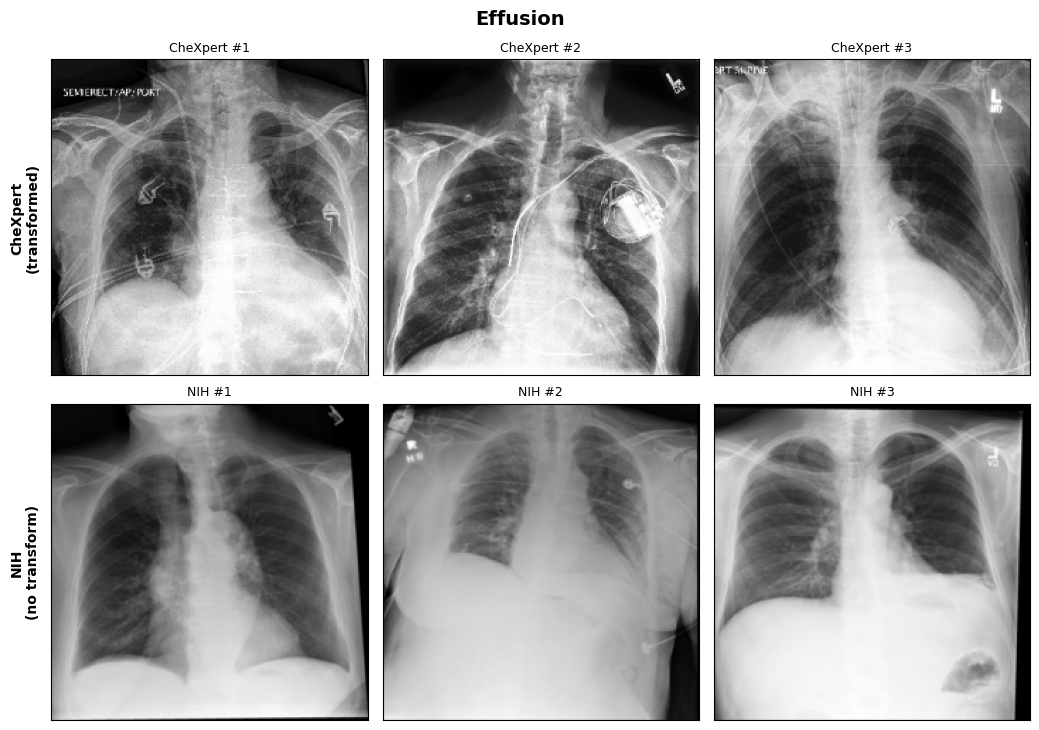

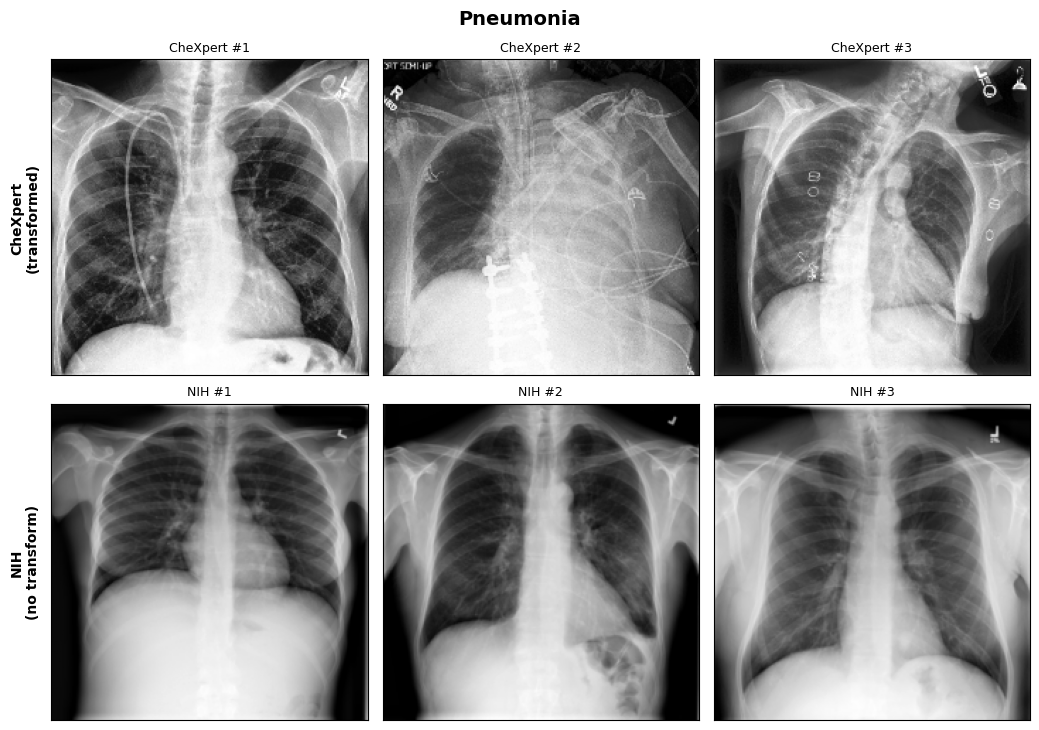

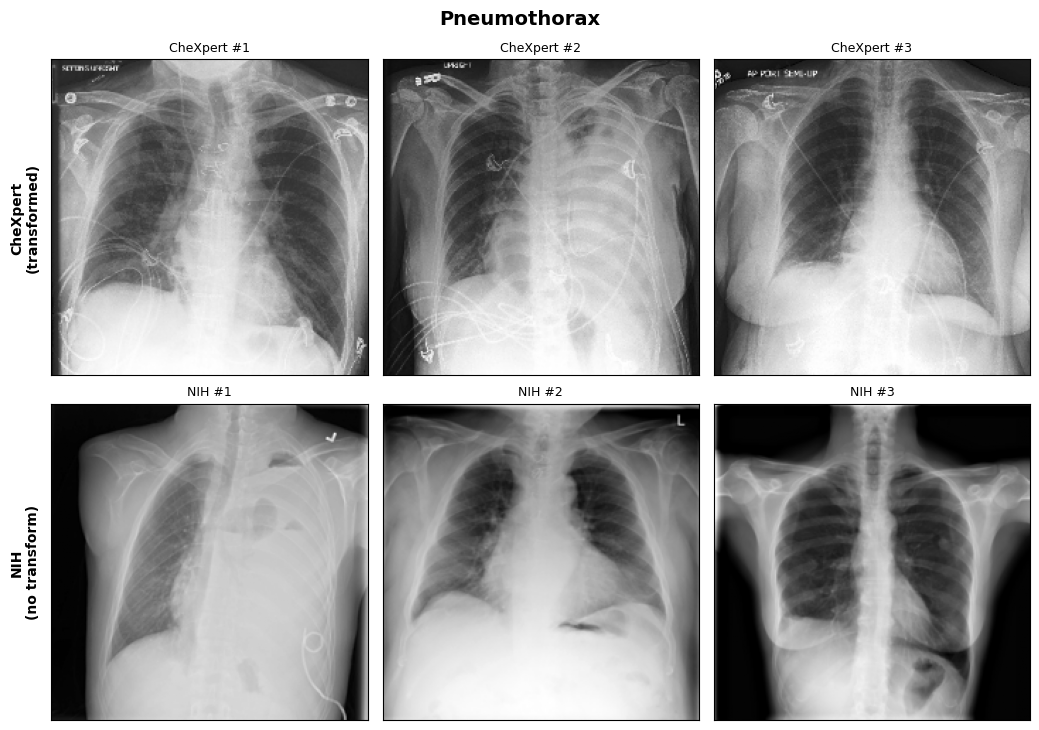

In [6]:
N_EX = 3        # examples per category per dataset

for category in CATEGORIES:
    no_path  = (category == 'No Pathology')
    path_idx = None if no_path else COMMON_PATHOLOGIES.index(category)

    chex_idxs = find_sample_indices(chex_tx,  path_idx, no_path, n=N_EX, seed=42)
    nih_idxs  = find_sample_indices(nih,       path_idx, no_path, n=N_EX, seed=42)

    # 2 rows (CheXpert / NIH), N_EX cols each
    fig, axes = plt.subplots(2, N_EX, figsize=(N_EX * 3.5, 7.5))
    fig.suptitle(f'{category}', fontsize=14, fontweight='bold')

    for col_i in range(N_EX):
        # CheXpert row
        ax = axes[0, col_i]
        if col_i < len(chex_idxs):
            arr = img_for_display(chex_tx[chex_idxs[col_i]]['img'])
            ax.imshow(arr, cmap='gray')
            ax.set_title(f'CheXpert #{col_i+1}', fontsize=9)
        else:
            ax.axis('off')
        ax.set_xticks([]); ax.set_yticks([])

        # NIH row
        ax = axes[1, col_i]
        if col_i < len(nih_idxs):
            arr = img_for_display(nih[nih_idxs[col_i]]['img'])
            ax.imshow(arr, cmap='gray')
            ax.set_title(f'NIH #{col_i+1}', fontsize=9)
        else:
            ax.axis('off')
        ax.set_xticks([]); ax.set_yticks([])

    # row labels
    axes[0, 0].set_ylabel('CheXpert\n(transformed)', fontsize=10,
                           fontweight='bold', rotation=90, labelpad=8)
    axes[1, 0].set_ylabel('NIH\n(no transform)', fontsize=10,
                           fontweight='bold', rotation=90, labelpad=8)

    plt.tight_layout()
    plt.show()